# Bright image segmentation 

In this notebook, we present a solution in order to crop organoid images that are considered as too bright to function under the previously encoded algorithm. Our implementation is the following:
- We load the images
- Resize the images into a 512 width and appropriate height (for dimensionality purpose for the  use of the Cellpose library)
- For each image, generate its corresponding Mask using the Cellpose library. Cellpose detects the organoids and generates a mask with multiple colors.
- Transform the mask so that every detected shape is of the same color
- Resize the mask to the size of the original image
- Apply the mask on the image in order to highlight the contours of each organoid
- Transform the resulting image by applying a filter that inverses bright and dark colours
- Apply a modified version of the algorithm. In this modified version, we:
    - run the algorithm on the transformed image, so it detects as many organoids as possible
    - save the coordinates of the crops
    - perform the segmentation of the organoids found on the transformed image on the original image
    - save them in a folder called 'output'.

In [201]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from pathlib import Path, PureWindowsPath 
from SharedWithJeanne import functions


from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
#Import of the necessary Modules:
import os
import re
import sys
import math
import time
from shutil import copy
from pathlib import Path, PureWindowsPath 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import skimage
import skimage.io
import skimage.filters as skf
import skimage.morphology as skm
from skimage.external.tifffile import TiffFile
from skimage.external.tifffile import TiffWriter
from scipy.ndimage.morphology import binary_fill_holes as fillHoles
from cellpose.models import Cellpose
import timeit

from skimage.external.tifffile import TiffFile
from skimage.external.tifffile import TiffWriter

TORCH CUDA version not installed/working.
>>> GPU activated? 0


# 0. Image transformation

In this first part, we transform the bright images and save them in a new folder called `Transformed`. These new images will allow us to apply the well-cropping algorithm and obtain better perfomance.

In [202]:
#### IMPORTANT ####
# Here is where you put all the inputs that will help the algorithm know where it should take the data
# and what kind of data we are working with

# put the directory where the images are
directory = 'SharedWithJeanne/test_maria/'
use_masks = True

radius = 420
minsize = 6000
maxsize = 800000

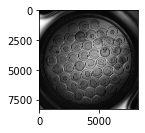

In [203]:
from cellpose import utils
from PIL import Image

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
#imgs = [skimage.io.imread(f) for f in files]
#nimg = len(imgs)
files = []
for file in Path(directory).iterdir():
    if str(file).endswith('tif'):
        files.append(str(file))
#files = [directory + '20201123_hSI_recSato_batch1_D5_3.tif' ]
imgs = [skimage.io.imread(f, as_gray=True) for f in files]
nimg = len(imgs)

if use_masks:
    
    new_imgs = []
    basewidth = 512

    for img_ in files:

        img = Image.open(img_)
        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)
        new_imgs.append(img)

    new_imgs = [np.array(im) for im in new_imgs]

plt.figure(figsize=(6,6))
for k,img in enumerate(imgs[:3]):
    plt.subplot(1,3,k+1)
    plt.imshow(img, cmap='gray')

# 0.1 Generate mask (only if image considered as difficult)

In [204]:
# RUN CELLPOSE

if use_masks:
    imgs_2D = new_imgs

    from cellpose import models

    # DEFINE CELLPOSE MODEL
    # model_type='cyto' or model_type='nuclei'
    model = models.Cellpose(gpu=use_GPU, model_type='cyto')

    # define CHANNELS to run segementation on
    # grayscale=0, R=1, G=2, B=3
    # channels = [cytoplasm, nucleus]
    # if NUCLEUS channel does not exist, set the second channel to 0
    # channels = [0,0]
    # IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
    # channels = [0,0] # IF YOU HAVE GRAYSCALE
    # channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
    # channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

    # or if you have different types of channels in each image
    channels = [[2,3], [0,0], [0,0], [0,0]]

    # if diameter is set to None, the size of the cells is estimated on a per image basis
    # you can set the average cell `diameter` in pixels yourself (recommended) 
    # diameter can be a list or a single number for all images

    masks, flows, styles, diams = model.eval(imgs_2D, diameter=30, flow_threshold=None, channels=[0,0])


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 18.26s; flow+mask computation 0.78
estimated masks for 1 image(s) in 19.06 sec
>>>> TOTAL TIME 19.06 sec


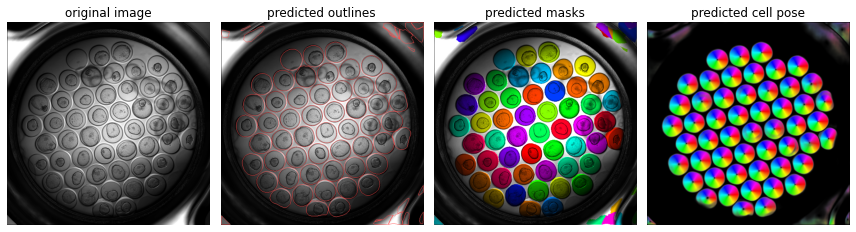

In [205]:
# DISPLAY RESULTS
from cellpose import plot
if use_masks:
    nimg = len(imgs_2D)
    for idx in range(nimg):
        maski = masks[idx]
        flowi = flows[idx][0]

        fig = plt.figure(figsize=(12,5))
        plot.show_segmentation(fig, new_imgs[idx], maski, flowi, channels=channels[idx])
        plt.tight_layout()
        plt.show()

In [206]:
# save example of original mask generated by Cellpose

if use_masks:
    temp_mask = masks[0].copy()
    temp_img = temp_mask*new_imgs[0]
#plt.imshow(temp_img, cmap='gray')

In [207]:
# change mask so that every cell is of same color. This will allow us to have more defined organoids
# leading the algorithm to a better performance when detecting the wells
if use_masks:
    for mask in masks:
        mask[mask != 0] = 255

In the following plot, we can understand why the mask filtering is necessary in order to guarantee a future better precision in the organoids detection of the algorithm.

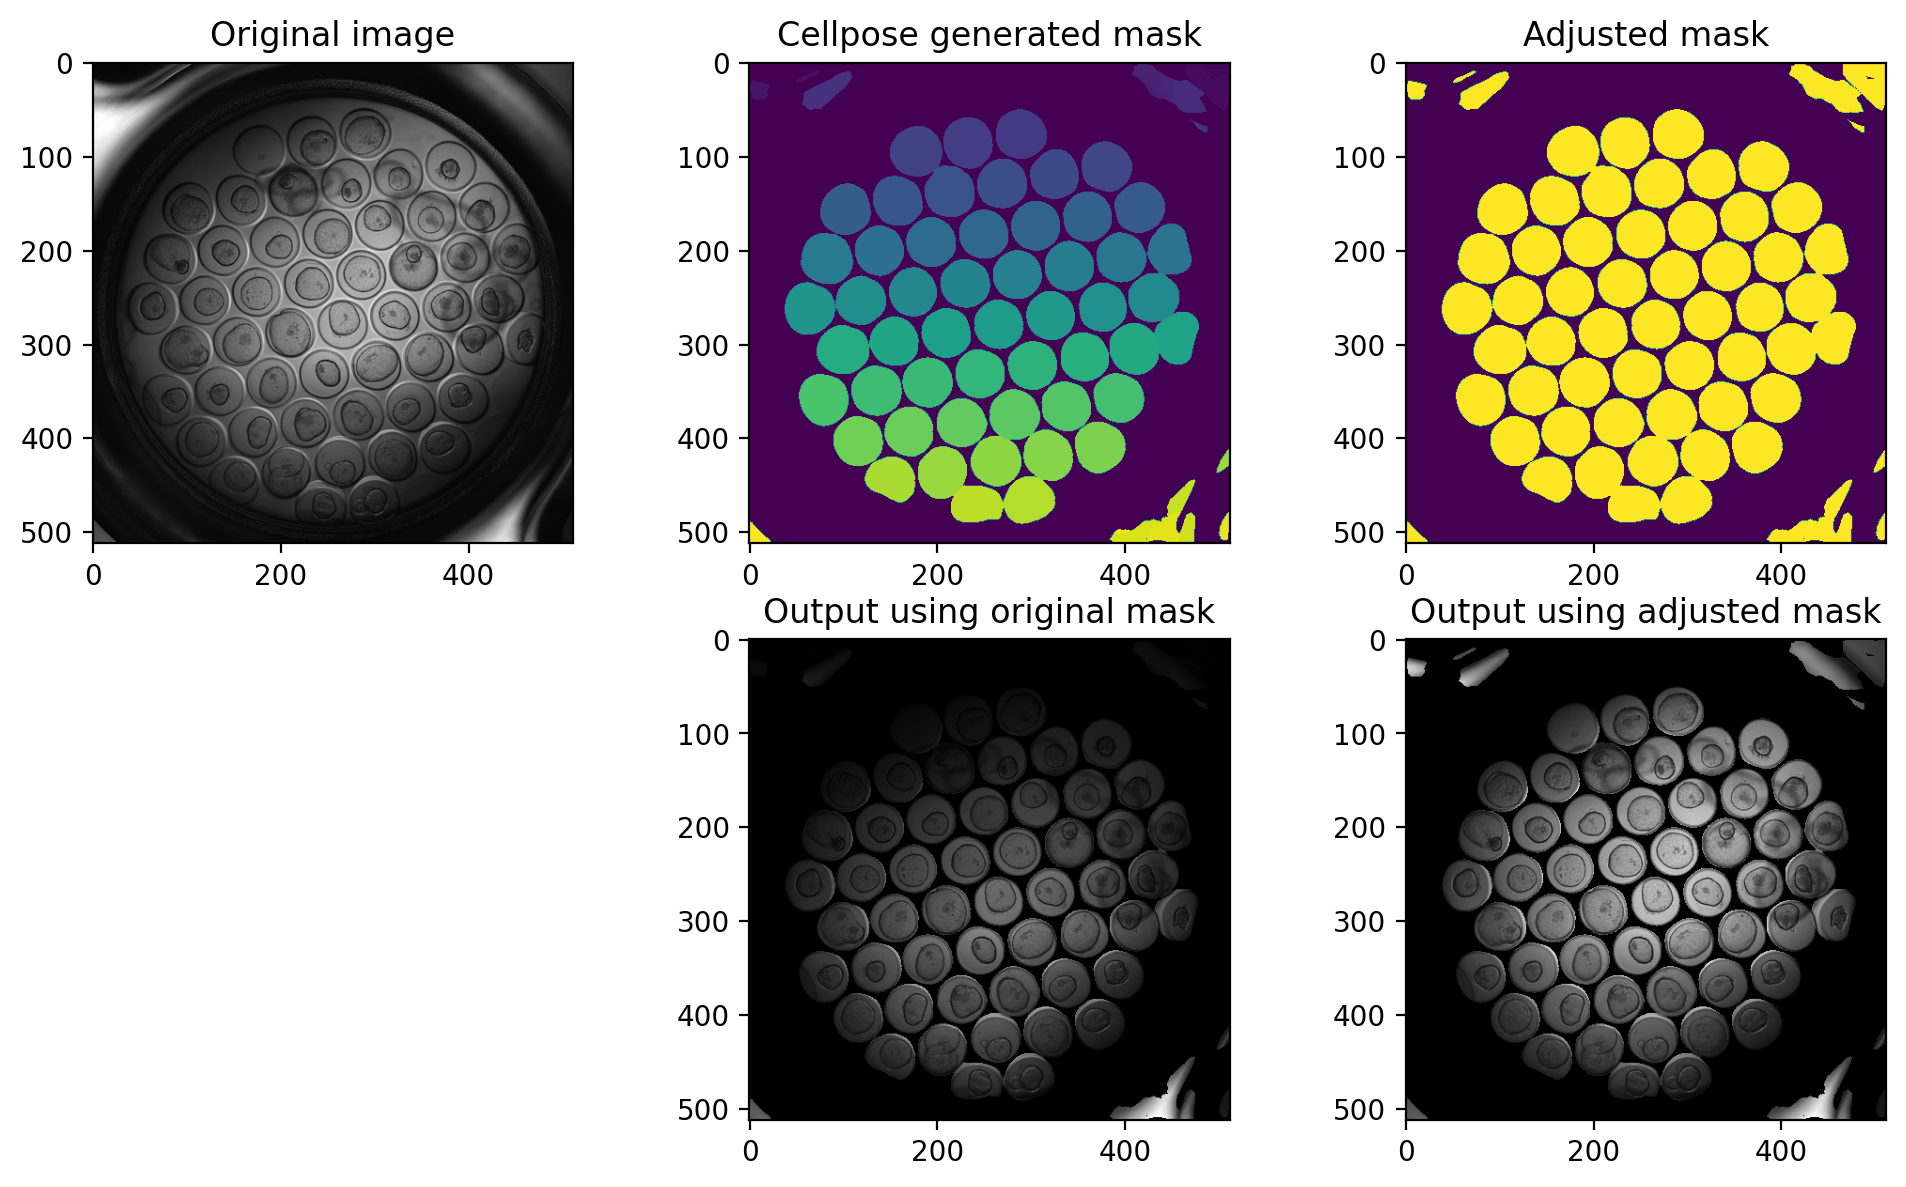

In [208]:
if use_masks:
    fig=plt.figure(figsize=(12, 7), dpi=200)
    columns = 2
    rows = 3
    ax = []
    ax.append(fig.add_subplot(2, 3, 1))
    ax[-1].set_title("Original image") 
    plt.imshow(new_imgs[0], cmap='gray')
    ax.append(fig.add_subplot(2, 3, 2))
    ax[-1].set_title("Cellpose generated mask") 
    plt.imshow(temp_mask)
    ax.append(fig.add_subplot(2, 3, 3))
    ax[-1].set_title("Adjusted mask") 
    plt.imshow(masks[0])
    #fig.add_subplot(2, 3, 4)
    #plt.imshow(temp_mask)
    ax.append(fig.add_subplot(2, 3, 5))
    ax[-1].set_title("Output using original mask") 
    plt.imshow(temp_img, cmap='gray')
    ax.append(fig.add_subplot(2, 3, 6))
    ax[-1].set_title("Output using adjusted mask") 
    plt.imshow(masks[0]*new_imgs[0], cmap='gray')

    #ax.append( fig.add_subplot(rows, columns, i+1) )
        #ax[-1].set_title("ax:"+str(i)) 

### Resize the masks

Now that we have the mask for the image (remember, we had to resize the image with 512 width for the algorithm to work. The Cellpose complexity is exponential as the image size increases) we will just reformat the mask before applying it to the *original sized* organoid image.

In [190]:
from tqdm.notebook import tqdm

if use_masks:
    masks_updated = []
    masks_updated2 = []
    for mask in masks:
        arr = np.asarray(mask)
        new_mask = []
        new_mask2 = np.zeros((arr.shape[0], arr.shape[1]))
        for i in tqdm(range(arr.shape[0])):
            temp_ls = []
            for j in range(arr.shape[1]):    
                if arr[i][j]==0:
                    temp_ls.append(255)
                    new_mask2[i][j] = 255
                else:
                    temp_ls.append(0)
                    new_mask2[i][j]=0
            new_mask.append(temp_ls)
        masks_updated.append(np.array(new_mask).astype('uint8'))
        masks_updated2.append(new_mask2)

In [210]:
if use_masks:
    resized_masks_updated = []
    for i, mask in enumerate(masks):
        # we want to rescale the mask to the size of its corresponding image
        basewidth = imgs[i].shape[0]

        mask_img = Image.fromarray(mask)
        wpercent = (basewidth/float(mask_img.size[0]))
        hsize = int((float(mask_img.size[1])*float(wpercent)))
        mask_img = mask_img.resize((basewidth,hsize), Image.ANTIALIAS)
        resized_masks_updated.append(np.asarray(mask_img))
        #img.save('somepic.jpg')

In [211]:
if use_masks:
    another_list = []
    for mask in resized_masks_updated:
        arr = np.asarray(mask).copy()
        
        arr[arr > 200] = 255
        
        another_list.append(arr.astype('uint8'))


In [212]:
resized_masks_updated = another_list.copy()

# 0.2 Run for all

In [196]:
from pathlib import Path, PureWindowsPath 
new_paths = []

outFolder = 'Transformed/'
outFolder8bit = 'Transformed_8bit/'
outFolderOutput = 'output'

Path(directory + outFolder).mkdir(exist_ok = False)
Path(directory + outFolder + outFolder8bit).mkdir(exist_ok = False)
Path(directory + outFolder + outFolder8bit + outFolderOutput).mkdir(exist_ok = False)
Path(directory + outFolder + outFolderOutput).mkdir(exist_ok = False)

for file in files:
    n = len(file.rpartition('/'))
    title = ''.join([el for i,el in enumerate(file.rpartition('/')) if i<n-1])
    title = title + outFolder + 'transformed_'+ file.rpartition('/')[-1]
    new_paths.append(title)

In [197]:
if use_masks:
    for i, path in enumerate(new_paths):
        with TiffWriter(path, bigtiff = False) as writer:
                writer.save(np.asarray(resized_masks_updated[i]))
                writer.close()
else:
    for i, path in enumerate(new_paths):
            with TiffWriter(path, bigtiff = False) as writer:
                writer.save(np.asarray(imgs[i]))
                writer.close() 

# 1. Transform to 8-bit/manual part (need to find how to do it in Python)
==> not needed anymore, done above

This part is the most painful of this process as we need to do it by hand. So gar, we have our transformed images that have been saved in a new folder called `Transformed`. However, these images need to be saved as 8-bit images. To do so we do to https://ij.imjoy.io/. For each image in the `Transformed` folder, import the image (File > Import > Select as Local File). For the imported image, changed it to an 8-bit format (Image > Type > 8-bit). Such transformed 8-bit images should be saved in a new folder called `Transformed_8bit` that should be inside the `Transformed` folder.

# 2. Transformed images cropping

In this second part, we apply the usual algorithm for the cropping of the wells. It works well on our newly generated images as they have been transformed and their brightness is not a problem anymore. However, we are not cropping the original images, but their transformed versions. So, in the code below, we save the coordinates of the crop in order to apply a final crop to the original bright images.

In [198]:
directory2 = directory + 'Transformed/'

In [199]:
# dictionary with, for each file its associated squares
d_squares, d_centroids, d_folders = functions.returnCoord(folder=directory2, radius=radius, minsize=minsize, maxsize=maxsize)


the file list in folder  SharedWithJeanne/test_maria/Transformed/  is 
 ['SharedWithJeanne/test_maria/Transformed/transformed_20210222_mLOrg_D14._16.tif']


the file list in folder  SharedWithJeanne/test_maria/  is 
 ['SharedWithJeanne/test_maria/20210222_mLOrg_D14._16.tif']


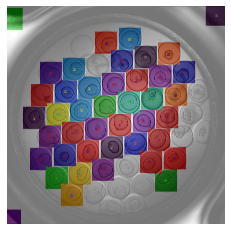

Time for file  1 :  20.13970352600154  s



In [200]:
functions.crop_original_img(d_squares, d_centroids, d_folders, directory)

In [251]:
segmentation(directory + 'Transformed/output/')

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\01.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\02.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\03.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\04.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\05.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\06.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\07.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\08.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\09.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_se

processing 1 image(s)
time spent: running network 2.24s; flow+mask computation 0.15
estimated masks for 1 image(s) in 2.41 sec
>>>> TOTAL TIME 2.41 sec
Time for processing the file: 5.156294493000132 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\02.tif
processing 1 image(s)
time spent: running network 2.35s; flow+mask computation 0.13
estimated masks for 1 image(s) in 2.50 sec
>>>> TOTAL TIME 2.50 sec
Time for processing the file: 5.035547190000216 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\03.tif
processing 1 image(s)
time spent: running network 1.51s; flow+mask computation 0.39
estimated masks for 1 image(s) in 1.90 sec
>>>> TOTAL TIME 1.90 sec
Time for processing the file: 4.435913727999832 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\04.tif
processing 1 image(s)
time spent: running network 1.33s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.4

time spent: running network 1.40s; flow+mask computation 0.20
estimated masks for 1 image(s) in 1.61 sec
>>>> TOTAL TIME 1.61 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\28.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\29.tif
processing 1 image(s)
time spent: running network 1.24s; flow+mask computation 0.15
estimated masks for 1 image(s) in 1.40 sec
>>>> TOTAL TIME 1.40 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\29.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\30.tif
processing 1 image(s)
time spent: running network 1.43s; flow+mask computation 0.24
estimated masks for 1 image(s) in 1.68 sec
>>>> TOTAL TIME 1.68 sec
Time for processing the file: 3.9022500880000734 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\31.tif
processing 1 image(s)
time

time spent: running network 0.87s; flow+mask computation 0.14
estimated masks for 1 image(s) in 1.02 sec
>>>> TOTAL TIME 1.02 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser1\55.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\56.tif
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
Time for processing the file: 3.36150691200055 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\57.tif
processing 1 image(s)
time spent: running network 1.13s; flow+mask computation 0.13
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIME 1.27 sec
Time for processing the file: 3.511530959999618 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser1\58.tif
processing 1 image(s)
time spent: running network 1.38s; flow+mask computation 0.14
es

time spent: running network 1.24s; flow+mask computation 0.18
estimated masks for 1 image(s) in 1.43 sec
>>>> TOTAL TIME 1.43 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser2\01.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\02.tif
processing 1 image(s)
time spent: running network 1.19s; flow+mask computation 0.13
estimated masks for 1 image(s) in 1.33 sec
>>>> TOTAL TIME 1.33 sec
Time for processing the file: 3.4674365840000974 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\03.tif
processing 1 image(s)
time spent: running network 1.09s; flow+mask computation 0.16
estimated masks for 1 image(s) in 1.26 sec
>>>> TOTAL TIME 1.26 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser2\03.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\04.tif
processing 1 image(s)
time

time spent: running network 1.26s; flow+mask computation 0.17
estimated masks for 1 image(s) in 1.43 sec
>>>> TOTAL TIME 1.43 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser2\27.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\28.tif
processing 1 image(s)
time spent: running network 1.08s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.16 sec
>>>> TOTAL TIME 1.16 sec
Time for processing the file: 3.3657333629998902 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\29.tif
processing 1 image(s)
time spent: running network 1.39s; flow+mask computation 0.11
estimated masks for 1 image(s) in 1.52 sec
>>>> TOTAL TIME 1.52 sec
Time for processing the file: 3.8332806899998104 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\30.tif
processing 1 image(s)
time spent: running network 1.47s; flow+mask computation 0.22

time spent: running network 0.89s; flow+mask computation 0.15
estimated masks for 1 image(s) in 1.05 sec
>>>> TOTAL TIME 1.05 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser2\53.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\54.tif
processing 1 image(s)
time spent: running network 1.68s; flow+mask computation 0.25
estimated masks for 1 image(s) in 1.93 sec
>>>> TOTAL TIME 1.93 sec
Time for processing the file: 4.102446464999957 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\55.tif
processing 1 image(s)
time spent: running network 0.99s; flow+mask computation 0.18
estimated masks for 1 image(s) in 1.18 sec
>>>> TOTAL TIME 1.18 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser2\55.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser2\56.tif
processing 1 image(s)
time 

time spent: running network 1.04s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.14 sec
>>>> TOTAL TIME 1.14 sec
Time for processing the file: 3.386891113999809 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\01.tif
processing 1 image(s)
time spent: running network 1.29s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.39 sec
>>>> TOTAL TIME 1.39 sec
Time for processing the file: 3.833849095000005 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\02.tif
processing 1 image(s)
time spent: running network 1.57s; flow+mask computation 0.11
estimated masks for 1 image(s) in 1.68 sec
>>>> TOTAL TIME 1.68 sec
Time for processing the file: 4.135640239000168 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\03.tif
processing 1 image(s)
time spent: running network 1.66s; flow+mask computation 0.17
estimated masks for 1 image(s) in 1.84 sec
>>>> TOTAL TIME 

time spent: running network 1.50s; flow+mask computation 0.24
estimated masks for 1 image(s) in 1.75 sec
>>>> TOTAL TIME 1.75 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser3\27.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\28.tif
processing 1 image(s)
time spent: running network 1.42s; flow+mask computation 0.28
estimated masks for 1 image(s) in 1.71 sec
>>>> TOTAL TIME 1.71 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser3\28.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\29.tif
processing 1 image(s)
time spent: running network 1.40s; flow+mask computation 0.12
estimated masks for 1 image(s) in 1.52 sec
>>>> TOTAL TIME 1.52 sec
Time for processing the file: 3.8255281889996695 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\30.tif
processing 1 image(s)
time

time spent: running network 0.98s; flow+mask computation 0.18
estimated masks for 1 image(s) in 1.17 sec
>>>> TOTAL TIME 1.17 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser3\54.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\55.tif
processing 1 image(s)
time spent: running network 1.38s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.49 sec
>>>> TOTAL TIME 1.49 sec
Time for processing the file: 3.8222349350016884 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\56.tif
processing 1 image(s)
time spent: running network 1.30s; flow+mask computation 0.21
estimated masks for 1 image(s) in 1.53 sec
>>>> TOTAL TIME 1.53 sec
Time for processing the file: 4.002827747999618 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\57.tif
processing 1 image(s)
time spent: running network 1.31s; flow+mask computation 0.09


Time for processing the file: 3.6840086150004936 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\82.tif
processing 1 image(s)
time spent: running network 1.52s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.60 sec
>>>> TOTAL TIME 1.60 sec
Time for processing the file: 3.752810691999912 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\83.tif
processing 1 image(s)
time spent: running network 0.96s; flow+mask computation 0.16
estimated masks for 1 image(s) in 1.13 sec
>>>> TOTAL TIME 1.13 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser3\83.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser3\84.tif
processing 1 image(s)
time spent: running network 1.20s; flow+mask computation 0.32
estimated masks for 1 image(s) in 1.52 sec
>>>> TOTAL TIME 1.52 sec
Time for processing the file: 3.7803424459998496 s . 


Shared

time spent: running network 1.11s; flow+mask computation 0.16
estimated masks for 1 image(s) in 1.28 sec
>>>> TOTAL TIME 1.28 sec
Time for processing the file: 3.8741249300001073 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\19.tif
processing 1 image(s)
time spent: running network 1.26s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.37 sec
>>>> TOTAL TIME 1.37 sec
Time for processing the file: 3.7227861150004173 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\20.tif
processing 1 image(s)
time spent: running network 1.27s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.36 sec
Time for processing the file: 3.597914051999396 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\21.tif
processing 1 image(s)
time spent: running network 1.37s; flow+mask computation 0.18
estimated masks for 1 image(s) in 1.56 sec
>>>> TOTAL TIM

Time for processing the file: 3.9188606630013965 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\47.tif
processing 1 image(s)
time spent: running network 1.22s; flow+mask computation 0.21
estimated masks for 1 image(s) in 1.43 sec
>>>> TOTAL TIME 1.43 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser4\47.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\48.tif
processing 1 image(s)
time spent: running network 1.31s; flow+mask computation 0.23
estimated masks for 1 image(s) in 1.55 sec
>>>> TOTAL TIME 1.55 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser4\48.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\49.tif
processing 1 image(s)
time spent: running network 1.07s; flow+mask computation 0.11
estimated masks for 1 image(s) in 1.19 sec
>>>> TOTAL TIME 1.19 sec
Time

time spent: running network 1.27s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.35 sec
>>>> TOTAL TIME 1.35 sec
Time for processing the file: 3.772257587999775 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\75.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.36 sec
Time for processing the file: 3.4860750829993776 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\76.tif
processing 1 image(s)
time spent: running network 0.90s; flow+mask computation 0.17
estimated masks for 1 image(s) in 1.09 sec
>>>> TOTAL TIME 1.09 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_D6_SUN96_ser4\76.tif. 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_D6_SUN96_ser4\77.tif
processing 1 image(s)
time spent: running network 1.25s; flow+mask computation 0.08


Time for processing the file: 3.9556193450007413 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_1\19.tif
processing 1 image(s)
time spent: running network 1.45s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.55 sec
>>>> TOTAL TIME 1.55 sec
Time for processing the file: 3.9167277540000214 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_1\20.tif
processing 1 image(s)
time spent: running network 1.21s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.30 sec
>>>> TOTAL TIME 1.30 sec
Time for processing the file: 3.585398391000126 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_1\21.tif
processing 1 image(s)
time spent: running network 1.43s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.50 sec
>>>> TOTAL TIME 1.50 sec
Time for processing the file: 3.1426324900003237 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transforme

time spent: running network 1.21s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.30 sec
>>>> TOTAL TIME 1.30 sec
Time for processing the file: 3.678161103000093 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_3\05.tif
processing 1 image(s)
time spent: running network 1.24s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.33 sec
>>>> TOTAL TIME 1.33 sec
Time for processing the file: 3.8020096990003367 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_3\06.tif
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.24 sec
>>>> TOTAL TIME 1.24 sec
Time for processing the file: 3.9041163889996824 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_3\07.tif
processing 1 image(s)
time spent: running network 1.42s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.51 sec
>>>> TOTAL TIM

time spent: running network 1.68s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.75 sec
>>>> TOTAL TIME 1.75 sec
Time for processing the file: 4.092675230998793 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_4\13.tif
processing 1 image(s)
time spent: running network 2.10s; flow+mask computation 0.06
estimated masks for 1 image(s) in 2.17 sec
>>>> TOTAL TIME 2.17 sec
Time for processing the file: 4.522171858001457 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_4\14.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.36 sec
Time for processing the file: 3.6959812639997836 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_4\15.tif
processing 1 image(s)
time spent: running network 1.76s; flow+mask computation 0.13
estimated masks for 1 image(s) in 1.90 sec
>>>> TOTAL TIME

time spent: running network 1.75s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.84 sec
>>>> TOTAL TIME 1.84 sec
Time for processing the file: 4.232714202998977 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_5\19.tif
processing 1 image(s)
time spent: running network 1.32s; flow+mask computation 0.11
estimated masks for 1 image(s) in 1.43 sec
>>>> TOTAL TIME 1.43 sec
Time for processing the file: 3.8211523330010095 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_5\20.tif
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
Time for processing the file: 2.971858381999482 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row1_5\21.tif
processing 1 image(s)
time spent: running network 1.36s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.45 sec
>>>> TOTAL TIME

time spent: running network 1.34s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.44 sec
>>>> TOTAL TIME 1.44 sec
Time for processing the file: 3.8545055329996103 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_5\05.tif
processing 1 image(s)
time spent: running network 1.88s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.99 sec
>>>> TOTAL TIME 1.99 sec
Time for processing the file: 4.805170360001284 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_5\06.tif
processing 1 image(s)
time spent: running network 1.76s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.86 sec
>>>> TOTAL TIME 1.86 sec
Time for processing the file: 4.37618186400141 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_5\07.tif
processing 1 image(s)
time spent: running network 1.41s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.51 sec
>>>> TOTAL TIME 

time spent: running network 1.21s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.30 sec
>>>> TOTAL TIME 1.30 sec
Time for processing the file: 3.2761538600007043 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_6\14.tif
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
Time for processing the file: 3.0825447129991517 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_6\15.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.38 sec
>>>> TOTAL TIME 1.38 sec
Time for processing the file: 3.7219943560012325 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_6\16.tif
processing 1 image(s)
time spent: running network 1.40s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.49 sec
>>>> TOTAL TI

time spent: running network 1.95s; flow+mask computation 0.08
estimated masks for 1 image(s) in 2.05 sec
>>>> TOTAL TIME 2.05 sec
Time for processing the file: 4.476513008999973 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_8\03.tif
processing 1 image(s)
time spent: running network 1.30s; flow+mask computation 0.23
estimated masks for 1 image(s) in 1.53 sec
>>>> TOTAL TIME 1.53 sec
Time for processing the file: 3.1429940620000707 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_8\04.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_8\05.tif
processing 1 image(s)
time spent: running network 1.40s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.49 sec
>>>> TOTAL TIME 1.50 sec
Time for processing the file: 3.82952186699913 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate1_row2_8\06.tif
processing 1 image(s)
time spent: running network 1.70s; 

time spent: running network 1.46s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.56 sec
>>>> TOTAL TIME 1.56 sec
Time for processing the file: 3.936545190999823 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_1\16.tif
processing 1 image(s)
time spent: running network 1.15s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.23 sec
>>>> TOTAL TIME 1.23 sec
Time for processing the file: 3.5643263370002387 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_1\17.tif
processing 1 image(s)
time spent: running network 1.26s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.36 sec
Time for processing the file: 3.104886645998704 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_1\18.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.37 sec
>>>> TOTAL TIME

time spent: running network 1.33s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.42 sec
>>>> TOTAL TIME 1.42 sec
Time for processing the file: 3.5169269000016357 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_3\05.tif
processing 1 image(s)
time spent: running network 1.31s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.40 sec
>>>> TOTAL TIME 1.40 sec
Time for processing the file: 3.721739382001033 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_3\06.tif
processing 1 image(s)
time spent: running network 1.98s; flow+mask computation 0.08
estimated masks for 1 image(s) in 2.07 sec
>>>> TOTAL TIME 2.07 sec
Time for processing the file: 4.4981495779993566 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_3\07.tif
processing 1 image(s)
time spent: running network 1.26s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.37 sec
>>>> TOTAL TIM

time spent: running network 1.39s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.49 sec
>>>> TOTAL TIME 1.49 sec
Time for processing the file: 3.814335516999563 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_4\15.tif
processing 1 image(s)
time spent: running network 1.30s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.40 sec
>>>> TOTAL TIME 1.40 sec
Time for processing the file: 3.7821524889986904 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_4\16.tif
processing 1 image(s)
time spent: running network 1.53s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.62 sec
>>>> TOTAL TIME 1.62 sec
Time for processing the file: 4.087251110999205 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_4\17.tif
processing 1 image(s)
time spent: running network 1.23s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.33 sec
>>>> TOTAL TIME

time spent: running network 1.62s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.70 sec
>>>> TOTAL TIME 1.70 sec
Time for processing the file: 4.060663004000162 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_6\08.tif
processing 1 image(s)
time spent: running network 1.44s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.52 sec
>>>> TOTAL TIME 1.52 sec
Time for processing the file: 3.946240753000893 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_6\09.tif
processing 1 image(s)
time spent: running network 1.41s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.50 sec
>>>> TOTAL TIME 1.50 sec
Time for processing the file: 3.956110520000948 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_6\10.tif
processing 1 image(s)
time spent: running network 1.29s; flow+mask computation 0.06
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 

time spent: running network 1.27s; flow+mask computation 0.16
estimated masks for 1 image(s) in 1.44 sec
>>>> TOTAL TIME 1.44 sec
Time for processing the file: 4.1477808540003025 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_8\03.tif
processing 1 image(s)
time spent: running network 1.42s; flow+mask computation 0.14
estimated masks for 1 image(s) in 1.57 sec
>>>> TOTAL TIME 1.57 sec
Time for processing the file: 4.217813778001073 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_8\04.tif
processing 1 image(s)
time spent: running network 1.33s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.43 sec
>>>> TOTAL TIME 1.43 sec
Time for processing the file: 3.8541551580001396 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row1_8\05.tif
processing 1 image(s)
time spent: running network 1.16s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.27 sec
>>>> TOTAL TIM

time spent: running network 1.28s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.37 sec
Time for processing the file: 3.9472419200010336 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_1\11.tif
processing 1 image(s)
time spent: running network 1.63s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.72 sec
>>>> TOTAL TIME 1.72 sec
Time for processing the file: 4.0528332850008155 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_1\12.tif
processing 1 image(s)
time spent: running network 1.29s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.40 sec
>>>> TOTAL TIME 1.40 sec
Time for processing the file: 3.871881692999523 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_1\13.tif
processing 1 image(s)
time spent: running network 1.46s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.57 sec
>>>> TOTAL TIM

time spent: running network 1.27s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.37 sec
>>>> TOTAL TIME 1.37 sec
Time for processing the file: 3.840776012000788 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_3\03.tif
SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_3\04.tif
processing 1 image(s)
time spent: running network 1.29s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.38 sec
>>>> TOTAL TIME 1.39 sec
Time for processing the file: 3.781722185000035 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_3\05.tif
processing 1 image(s)
time spent: running network 1.57s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.66 sec
>>>> TOTAL TIME 1.66 sec
Time for processing the file: 4.205016718999104 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_3\06.tif
processing 1 image(s)
time spent: running network 1.47s; 

Time for processing the file: 3.7763160599988623 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_4\13.tif
processing 1 image(s)
time spent: running network 1.32s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.41 sec
>>>> TOTAL TIME 1.41 sec
Time for processing the file: 3.796871161999661 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_4\14.tif
processing 1 image(s)
time spent: running network 1.37s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.47 sec
>>>> TOTAL TIME 1.47 sec
Time for processing the file: 3.8295573340001283 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_4\15.tif
processing 1 image(s)
time spent: running network 1.47s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.58 sec
>>>> TOTAL TIME 1.58 sec
Time for processing the file: 4.092444478001198 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed

Time for processing the file: 4.384710778998851 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_6\02.tif
processing 1 image(s)
time spent: running network 1.69s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.79 sec
>>>> TOTAL TIME 1.79 sec
Time for processing the file: 4.2893375379990175 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_6\03.tif
processing 1 image(s)
time spent: running network 1.11s; flow+mask computation 0.10
estimated masks for 1 image(s) in 1.22 sec
>>>> TOTAL TIME 1.22 sec
Time for processing the file: 3.8501274840000406 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_6\04.tif
processing 1 image(s)
time spent: running network 1.44s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.54 sec
>>>> TOTAL TIME 1.54 sec
Time for processing the file: 4.376960888999747 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed

time spent: running network 1.29s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.37 sec
>>>> TOTAL TIME 1.37 sec
Time for processing the file: 3.159882544001448 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_7\11.tif
processing 1 image(s)
time spent: running network 1.14s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.24 sec
>>>> TOTAL TIME 1.24 sec
Time for processing the file: 3.64466569599972 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_7\12.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.38 sec
>>>> TOTAL TIME 1.38 sec
Time for processing the file: 3.750052602001233 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_7\13.tif
processing 1 image(s)
time spent: running network 1.53s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.61 sec
>>>> TOTAL TIME 1

Time for processing the file: 3.929704681999283 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_8\15.tif
processing 1 image(s)
time spent: running network 1.28s; flow+mask computation 0.07
estimated masks for 1 image(s) in 1.35 sec
>>>> TOTAL TIME 1.35 sec
Time for processing the file: 3.1937943379998615 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_8\16.tif
processing 1 image(s)
time spent: running network 1.42s; flow+mask computation 0.09
estimated masks for 1 image(s) in 1.52 sec
>>>> TOTAL TIME 1.52 sec
Time for processing the file: 3.876836552999521 s . 


SharedWithJeanne/mISC_tif_save/Transformed/output/

 transformed_Plate2_row2_8\17.tif
processing 1 image(s)
time spent: running network 1.27s; flow+mask computation 0.08
estimated masks for 1 image(s) in 1.36 sec
>>>> TOTAL TIME 1.36 sec
Cellpose failed for file: SharedWithJeanne/mISC_tif_save/Transformed/output/transformed_Plate2_row2_8\17.tif. 


SharedW